In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [3]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y


def get_KDDCUP99REV(PATH, seed, percAnomalies = 0.01, scale = True, show = False):
    
    columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_hot_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate', 'label']
    
    df = pd.read_csv(PATH, header=None, names=columns)
    discreteCol = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_hot_login', 'is_guest_login']
    
    names = []
    oneHot = dict()
    for name in discreteCol:
        n, t = _encode_text_dummy(df, name)
        names.extend(n)
        oneHot[name] = t
        
     # Delete nepture, smurf
    df_neptune = df[df['label'] == 'neptune.']
    df_smurf = df[df['label'] == 'smurf.']
    df = df.loc[~df.index.isin(df_neptune.index)]
    df = df.loc[~df.index.isin(df_smurf.index)]

    labels = df['label'].copy()
    labels[labels != 'normal.'] = 0 # anomalous
    labels[labels == 'normal.'] = 1 # normal

    df['label'] = labels
    normal = df[df['label'] == 1] 
    abnormal = df[df['label'] == 0]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)

    abnormal_1 = abnormal[:int(len(abnormal)*.5)+1]
    abnormal_2 = abnormal[int(len(abnormal)*.5)+1:]
    
    train_abnormal = abnormal_2[:int(len(abnormal_2)*percAnomalies)]
    
    test_size_ab = int(len(abnormal_1)*(3/4))
    val_size_ab = int(len(abnormal_1)*(1/4))

    test_size_n = int(.15 * (len(normal) + len(abnormal_1)) - test_size_ab + 1)
    val_size_n = int(.05 * (len(normal) + len(abnormal_1)) - val_size_ab + 1)

    train_size = int(len(normal) - val_size_n - test_size_n)+1

    train_normal = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size_n]
    test_normal = normal[train_size+val_size_n: ]

    val_abnormal = abnormal[:val_size_ab]
    test_abnormal = abnormal[val_size_ab:val_size_ab+test_size_ab]

    train_set = pd.concat((train_normal, train_abnormal))
    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))
    
    x_train, y_train = _to_xy(train_set, target='label')
    x_val, y_val = _to_xy(val_set, target='label')
    x_test, y_test = _to_xy(test_set, target='label')
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print(f'We use {len(abnormal_1)} anomalous records')
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == 1])} normal records and {len(x_train[y_train == 0])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == 1])} normal records and {len(x_val[y_val == 0])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == 1])} normal records and {len(x_test[y_test == 0])} abnormal records')

    selected_columns = dict()
    
    for name in discreteCol:
        cols = [col for col in names if name in col]
        tmp = []
        
        for c in cols:
            tmp.append(x_train.columns.get_loc(c))

        selected_columns[name] = tmp
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
    
    index = np.arange(0, len(columns)-len(discreteCol)-1)

    if scale:
        scaler = MinMaxScaler()
        scaler.fit(x_train[:, index])
        x_train[:, index] = scaler.transform(x_train[:, index])
        x_val[:, index] = scaler.transform(x_val[:, index])
        x_test[:, index] = scaler.transform(x_test[:, index])
        
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['selectedColumns'] = selected_columns
    dataset['discreteCol'] = discreteCol
    dataset['oneHot'] = oneHot
    dataset['index'] = index
    dataset['scaler'] = scaler
    
    return dataset

In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'
FILE = 'kddcup.data_10_percent_corrected'


SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)

DATASET = 'KDDCUP99_3P'

PATH = os.path.join(WORK_SPACE, FILE)

In [5]:
dataset = get_KDDCUP99REV(PATH, seed, percAnomalies = 0.03, show=True)

97278 normal records, 8752 anormal records
We use 4377 anomalous records
-----------------------------------------------------------------------------------------
There are 81454 records in training set
Training set is composed by 81323 normal records and 131 abnormal records
-----------------------------------------------------------------------------------------
There are 5083 records in validation set
Validation set is composed by 3989 normal records and 1094 abnormal records
-----------------------------------------------------------------------------------------
There are 15248 records in test set
Test set is composed by 11966 normal records and 3282 abnormal records


In [6]:
def plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, kldes, real_scores, fake_scores, i, DATASET, show = False):
    num_epochs = len(d_losses)
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), d_losses[:num_epochs], label='d loss')
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    

    plt.plot(range(1, num_epochs + 1), d_losses_val[:num_epochs], '--', label='d loss val')

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_losses_{DATASET}.pdf')
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    
    plt.plot(range(1, num_epochs + 1), bce_losses[:num_epochs], label=r'$\log(D(y))$')    
    plt.plot(range(1, num_epochs + 1), rec_losses[:num_epochs], label=r'MSE')    
    plt.plot(range(1, num_epochs + 1), kldes[:num_epochs], label='KLD') 

    plt.yscale('log')
    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_gen_loss_{DATASET}.pdf')  
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores[:num_epochs], label='real score')    

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_score_{DATASET}.pdf')

def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)



class Generator(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Generator, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), 
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.nf_out, self.nf_out * 2),
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.nf_out * 2, self.nf_in)
        )

        self.fc1 = nn.Linear(self.nf_out, self.nf_out)
        self.fc21 = nn.Linear(self.nf_out, self.z_dim)
        self.fc22 = nn.Linear(self.nf_out, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, self.nf_out)
        self.fc4 = nn.Linear(self.nf_out, self.nf_out)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x)
        h = self.fc1(conv)
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        return self.decoder(deconv_input)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        logits = self.decode(z)
        
        sampled_data = self.sigmoid(logits)
        
        return logits, mu, logvar, sampled_data
    
class Discriminator(nn.Module):

    def __init__(self, nc = 121, nf_out = 16, nout = 128):
        super(Discriminator, self).__init__()
        
        self.nc = nc
        self.nf_out = nf_out
        self.nout = nout
        
        self.main = nn.Sequential(
            # features extractor
            nn.Linear(self.nc, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout, self.nout * 2),
            nn.BatchNorm1d(self.nout * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout * 2, self.nout * 4),
            nn.BatchNorm1d(self.nout * 4, track_running_stats = False),
            nn.LeakyReLU(0.2),

            # classifier
            nn.Linear(self.nout * 4, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.ReLU(),

            nn.Linear(self.nout, self.nf_out * 4),
            nn.BatchNorm1d(self.nf_out * 4, track_running_stats = False),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 4, self.nf_out * 2),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out, 1),
            nn.Sigmoid()
        )
        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.main(x)
        return x.flatten()
    

class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
    
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss
    
    
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        self.mse = nn.MSELoss(reduction = 'mean')
        self.cel = nn.CrossEntropyLoss()
        

    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))

    def forward(self, true_data, fake_preds, sampled_data, z_mean, z_logvar, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        rec = self.mse(true_data, sampled_data)
        
        kld = self.KLD(z_mean, z_logvar)
        
        return gamma*log_p_y + rec + beta*kld, log_p_y, rec, kld
    
    
    
class AADNet(nn.Module):
    def __init__(self, device, nc):
        super(AADNet, self).__init__()
        self.device = device
        
        self.nc = nc

        self.D = Discriminator(nc = self.nc).to(self.device)
        self.G = Generator(nf_in = self.nc).to(self.device)

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-5)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        
        self.d_loss = DiscriminatorLoss()
        self.g_loss = GeneratorLoss()
        
        self.temperature = 1
        self.anneal = 0.9995
        
        self.criterion = nn.BCELoss()
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        logits, _, _, sampled_data = self.G(true_data)
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, z_mean, z_logvar, sampled_data = self.G(true_data)    
        fake_pred = self.D(sampled_data)

        gen_loss_batch, bce_loss, rec_loss, kl = self.g_loss(true_data, fake_pred, sampled_data, z_mean, z_logvar, self.temperature)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return gen_loss_batch, bce_loss, rec_loss, kl

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
            
    def evaluation(self, test_loader):
        self.D.eval()
        
        d_l = []
        ind = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
                d_loss_batch = self.criterion(y_pred, label)
                
            d_l.append(d_loss_batch.item())
        
        return np.mean(d_l)
    
    def predict(self, test_loader):
        self.D.eval()
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
            if i == 0:
                prediction = y_pred.cpu().round()
                y_true = label.cpu()
                yP = y_pred.cpu()
            else:
                prediction = torch.cat((prediction, y_pred.cpu().round()))
                y_true = torch.cat((y_true, label.cpu()))
                yP = torch.cat((yP, y_pred.cpu()))
                
            i += 1
            
        return prediction, y_true, yP
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
        
        
    def train(self, data_loader, data_abnormal_loader, val_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        rec_losses = np.zeros(num_epochs)
        bce_losses = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        
        d_losses_val = np.zeros(num_epochs)
        precision_abn = np.zeros(num_epochs)
        recall_abn = np.zeros(num_epochs)
        
        fake_scores_real = np.zeros(num_epochs)
        d_losses_fake_real = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                self.D.train()
                self.G.train()
                i = 0
                for batch in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)

                    ### Train autoencoder ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        g_loss, bce_loss, rec_loss, kl = self.G_step(batch,step_count)
                        

                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    
                    rec_losses[epoch] = rec_losses[epoch]*(i/(i+1.)) + rec_loss.item()*(1./(i+1.)) 
                    bce_losses[epoch] = bce_losses[epoch]*(i/(i+1.)) + bce_loss.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + kl.item()*(1./(i+1.))
                    
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    i += 1
                
                i = 0
                for batch in data_abnormal_loader:
                    batch = batch.to(self.device)
                    bs = batch.shape[0]
                    y_pred = self.D(batch)
                    
                    y_fake = torch.zeros(bs).to(device) ###
                    loss_batch = self.criterion(y_pred, y_fake)
                    loss_batch.backward()
                    self.d_optimizer.step()
                    
                    d_losses_fake_real[epoch] = d_losses_fake_real[epoch]*(i/(i+1.)) + loss_batch.item()*(1./(i+1.))
                    fake_scores_real[epoch] = fake_scores_real[epoch]*(i/(i+1.)) + y_pred.mean().item()*(1./(i+1.))
                    
                    i += 1
                    
                d_losses[epoch] = (d_losses[epoch] + d_losses_fake_real[epoch]) / 2
                    
                dLossVal = self.evaluation(val_loader)
                
                d_losses_val[epoch] = dLossVal
               
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f} | d_loss_val: {:.4f} | D(x_ab): {:.2f} '
                              .format(epoch+1, num_epochs, d_losses[epoch], g_losses[epoch], bce_loss.item(), rec_losses[epoch], kldes[epoch], real_scores[epoch], fake_scores[epoch], d_losses_val[epoch], fake_scores_real[epoch]))
                sys.stdout.flush()
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return d_losses[:epoch], g_losses[:epoch],rec_losses[:epoch], bce_losses[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch], d_losses_val[:epoch]

Iteration: 1
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0014 | g_loss: 0.1156 (9.09, 0.02, 0.85) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.4813 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2129 seconds



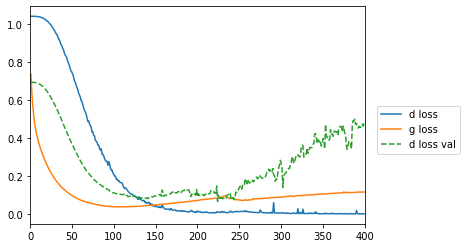

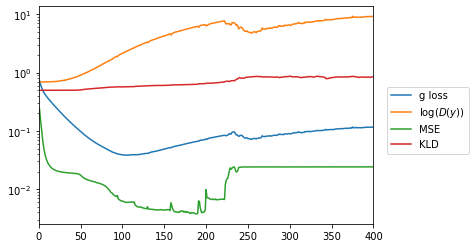

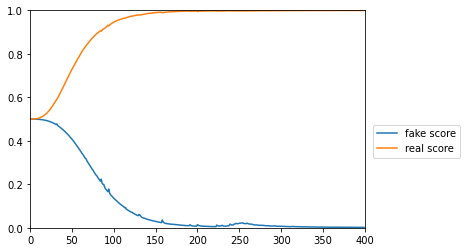

PR AUC: 0.99


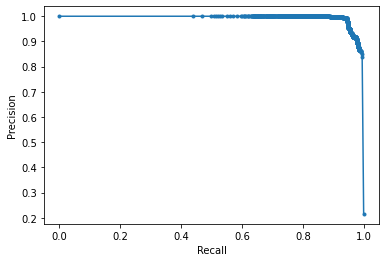

AUC: 1.00
Iteration: 2
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0013 | g_loss: 0.1211 (9.45, 0.02, 1.40) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1655 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2124 seconds



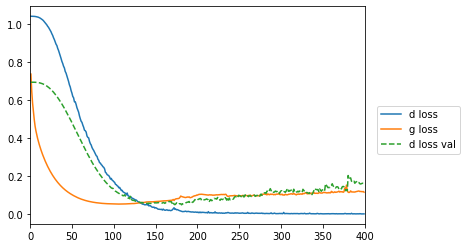

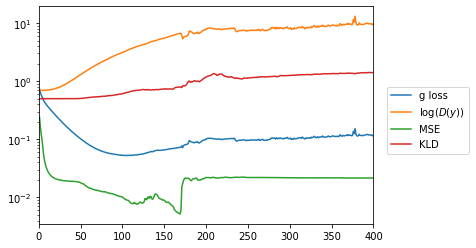

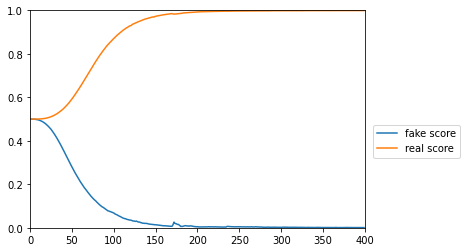

PR AUC: 0.98


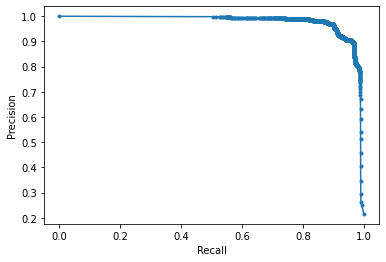

AUC: 0.99
Iteration: 3
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0019 | g_loss: 0.1148 (9.68, 0.02, 2.57) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2464 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2134 seconds



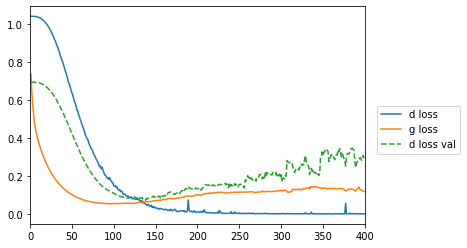

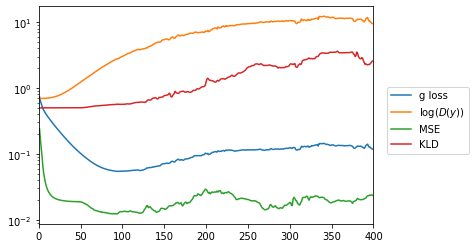

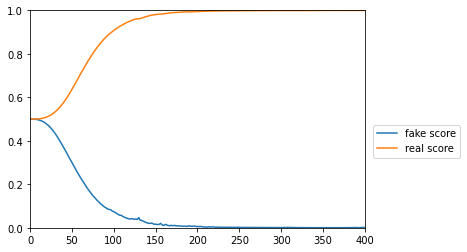

PR AUC: 0.99


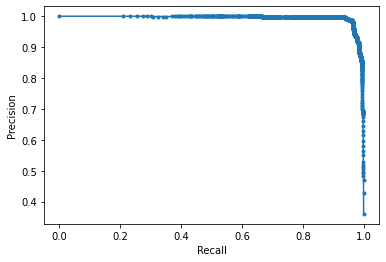

AUC: 1.00
Iteration: 4
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0014 | g_loss: 0.1091 (8.41, 0.02, 1.26) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3148 | D(x_ab): 0.00 
[INFO] Training phase... Elapsed time: 2130 seconds



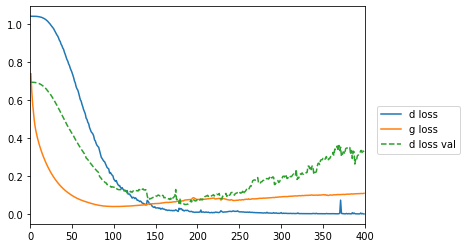

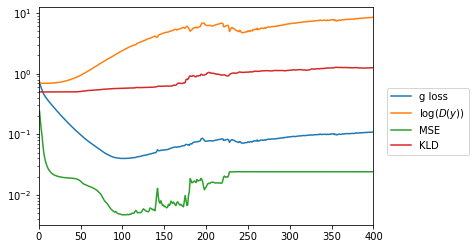

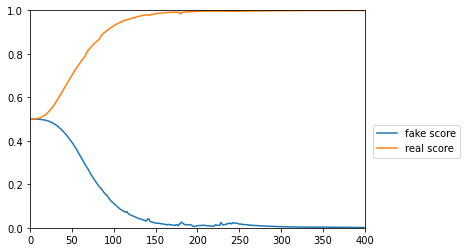

PR AUC: 0.99


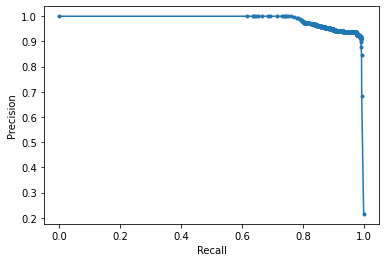

AUC: 0.99
Iteration: 5
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0065 | g_loss: 0.1025 (7.16, 0.03, 3.39) | D(x): 1.00 | D(G(x)): 0.01 | d_loss_val: 0.3268 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2127 seconds



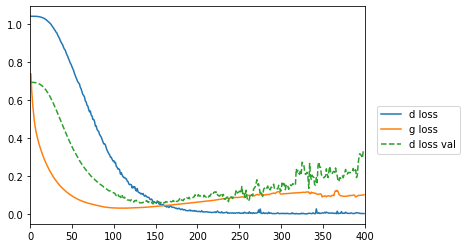

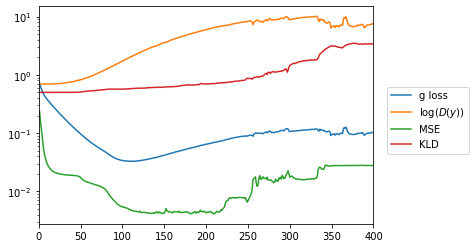

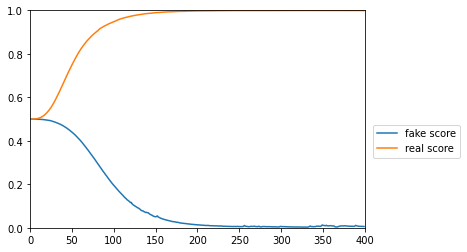

PR AUC: 0.99


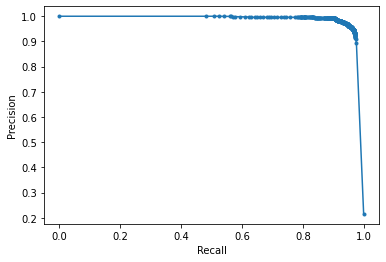

AUC: 0.99
Iteration: 6
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0027 | g_loss: 0.0959 (6.90, 0.02, 2.95) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2572 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2123 seconds



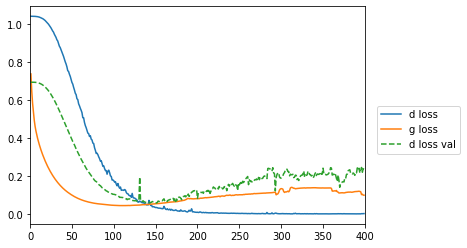

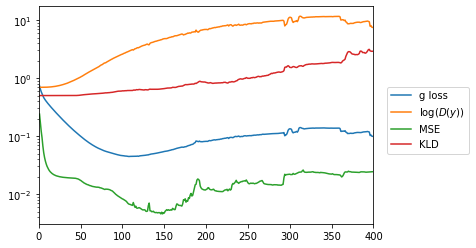

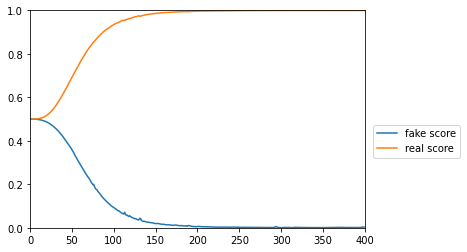

PR AUC: 0.98


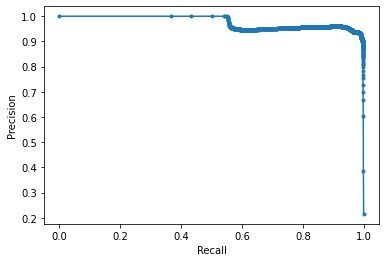

AUC: 0.99
Iteration: 7
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0013 | g_loss: 0.1089 (9.04, 0.02, 3.41) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3478 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2127 seconds



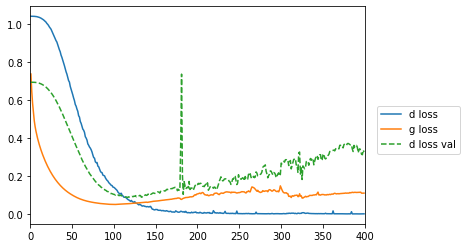

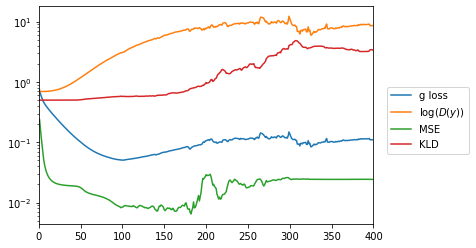

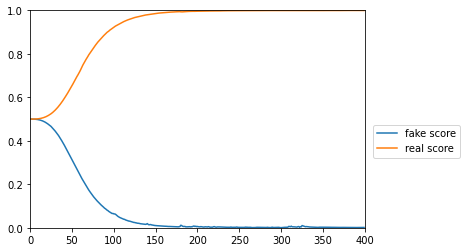

PR AUC: 0.91


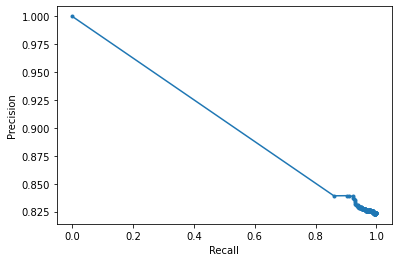

AUC: 0.97
Iteration: 8
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0010 | g_loss: 0.1141 (8.93, 0.02, 1.39) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3044 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2130 seconds



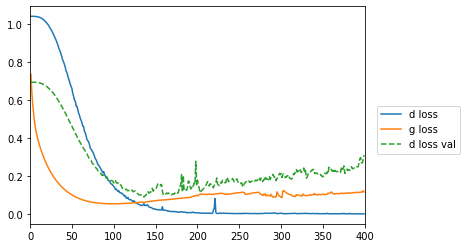

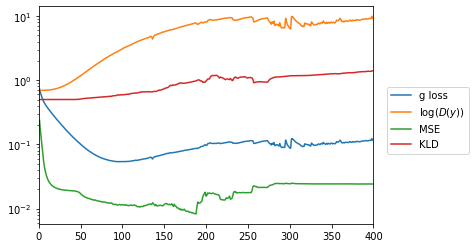

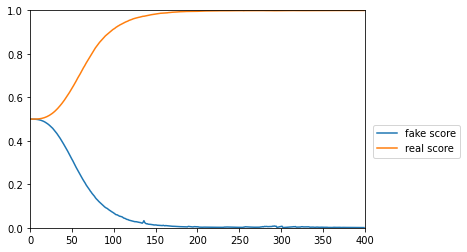

PR AUC: 0.95


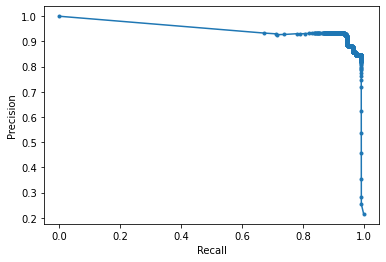

AUC: 0.98
Iteration: 9
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0037 | g_loss: 0.0991 (7.47, 0.02, 2.89) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3050 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 2130 seconds



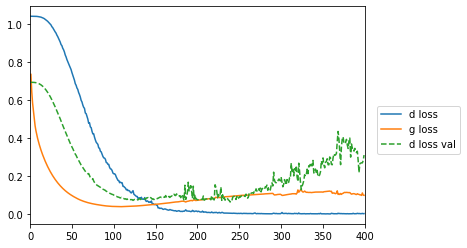

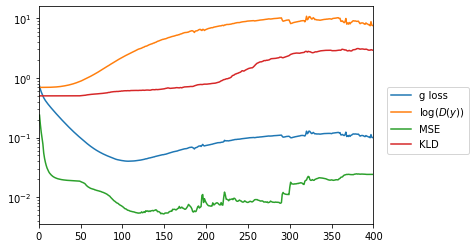

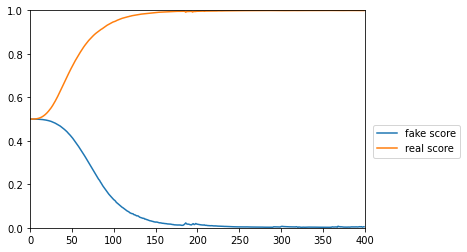

PR AUC: 0.99


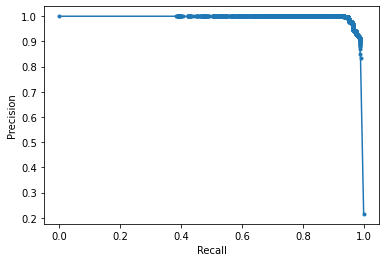

AUC: 0.99
Iteration: 10
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0012 | g_loss: 0.1227 (10.35, 0.02, 1.49) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3444 | D(x_ab): 0.00 
[INFO] Training phase... Elapsed time: 1763 seconds



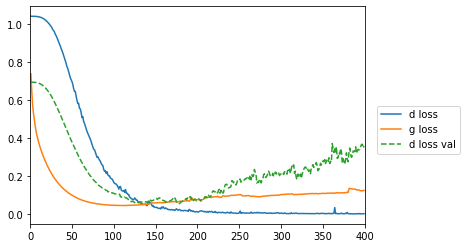

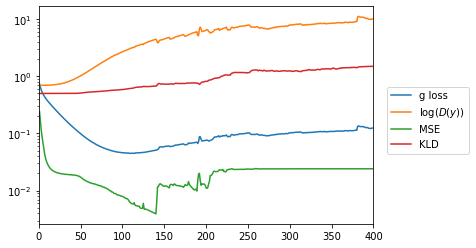

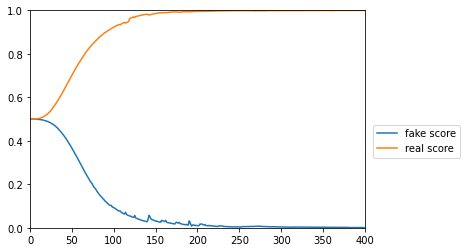

PR AUC: 0.98


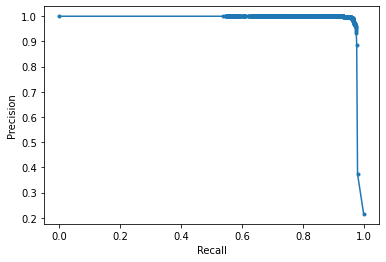

AUC: 0.98
Iteration: 11
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0018 | g_loss: 0.1123 (8.36, 0.03, 2.95) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2882 | D(x_ab): 0.00 
[INFO] Training phase... Elapsed time: 1666 seconds



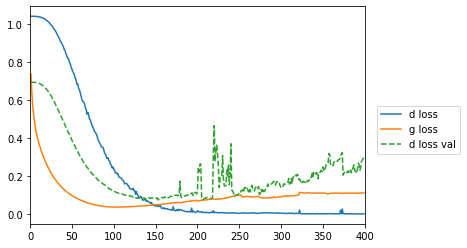

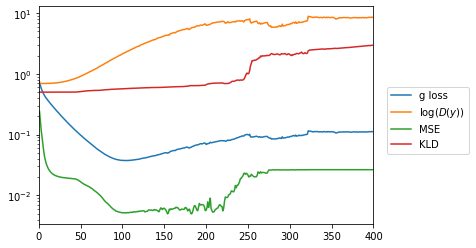

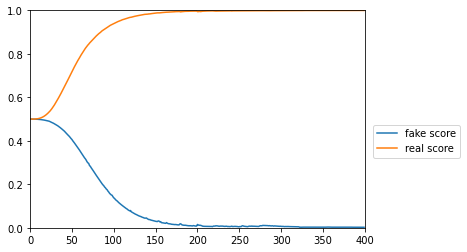

PR AUC: 0.98


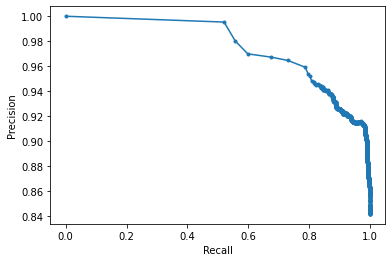

AUC: 0.99
Iteration: 12
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0006 | g_loss: 0.1297 (10.28, 0.03, 2.75) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2916 | D(x_ab): 0.00 
[INFO] Training phase... Elapsed time: 1666 seconds



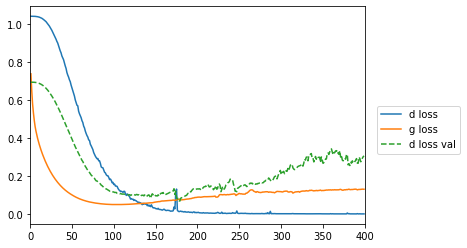

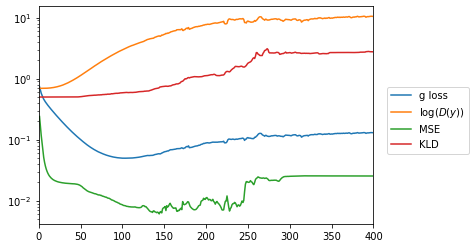

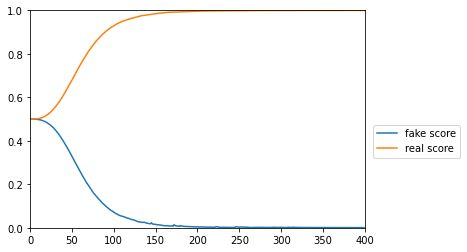

PR AUC: 0.98


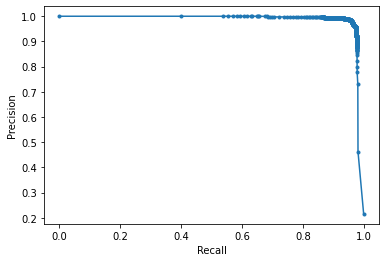

AUC: 0.99
Iteration: 13
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0047 | g_loss: 0.1156 (8.34, 0.02, 1.53) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3213 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1662 seconds



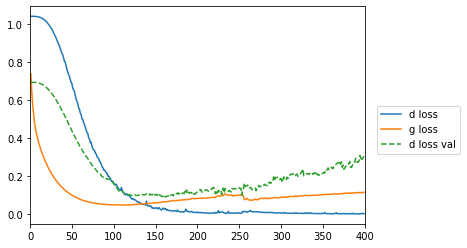

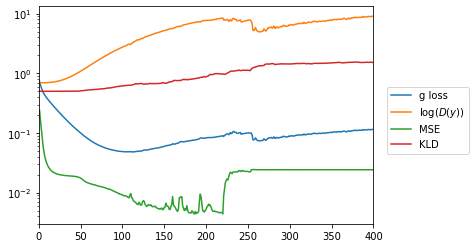

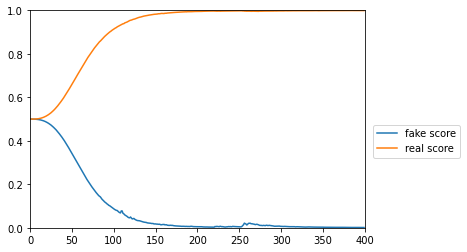

PR AUC: 0.98


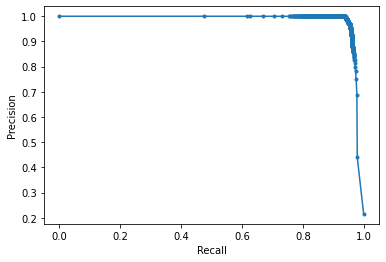

AUC: 0.98
Iteration: 14
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0015 | g_loss: 0.1150 (9.18, 0.03, 1.68) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3075 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1665 seconds



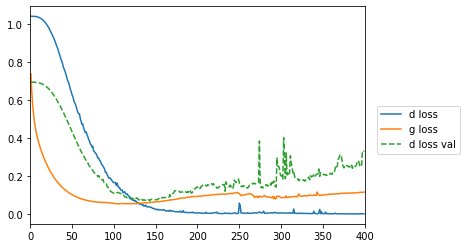

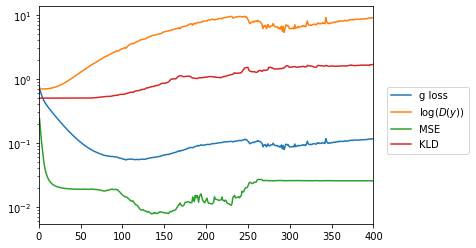

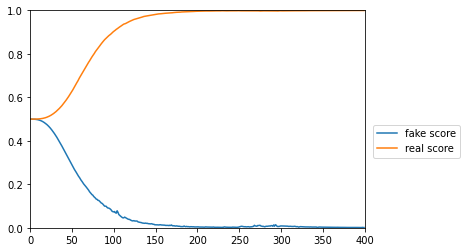

PR AUC: 0.98


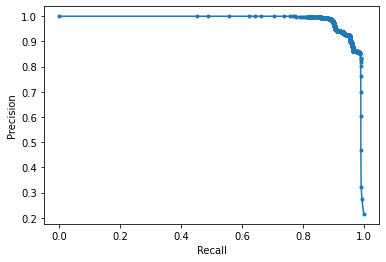

AUC: 0.99
Iteration: 15
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0132 | g_loss: 0.1207 (10.01, 0.02, 2.21) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.4659 | D(x_ab): 0.01 
[INFO] Training phase... Elapsed time: 1664 seconds



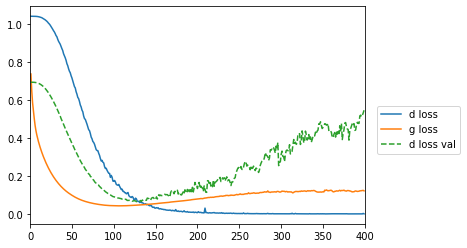

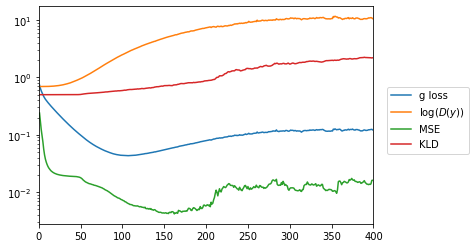

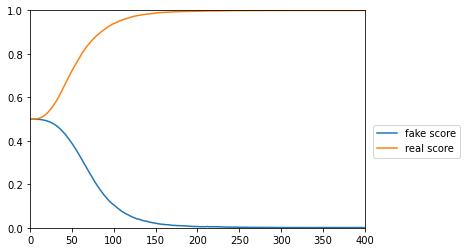

PR AUC: 0.99


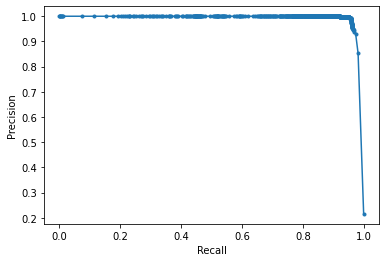

AUC: 0.99
Iteration: 16
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0035 | g_loss: 0.0986 (6.88, 0.03, 3.30) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3225 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1662 seconds



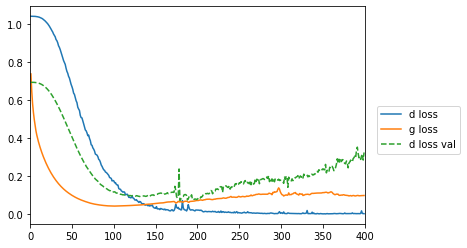

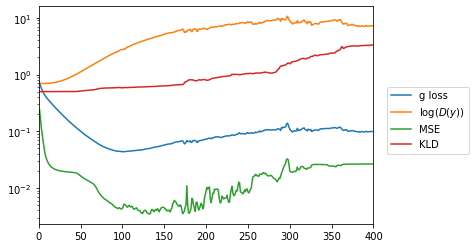

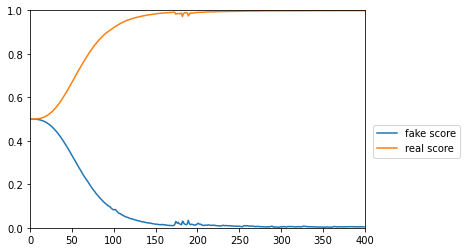

PR AUC: 0.93


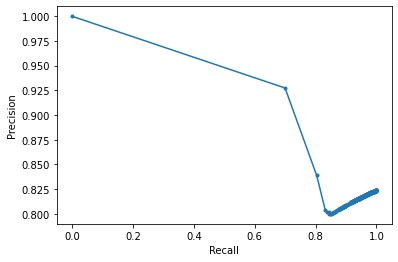

AUC: 0.98
Iteration: 17
[INFO] Starting training phase...
Epoch [211/400] | d_loss: 0.0076 | g_loss: 0.1074 (8.44, 0.02, 2.23) | D(x): 0.99 | D(G(x)): 0.00 | d_loss_val: 0.1004 | D(x_ab): 0.00  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [400/400] | d_loss: 0.0025 | g_loss: 0.1027 (7.50, 0.02, 1.10) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3080 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1667 seconds



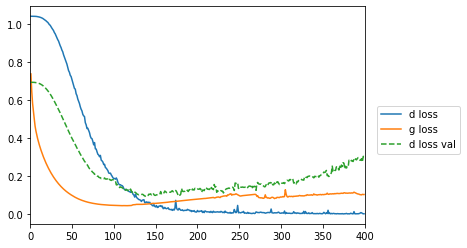

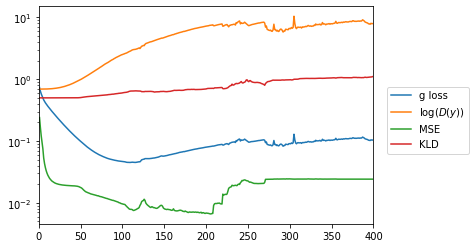

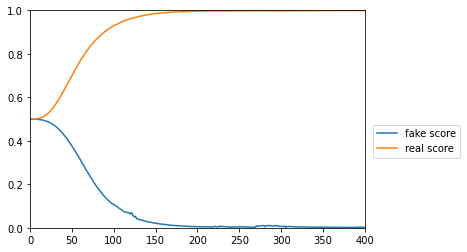

PR AUC: 0.99


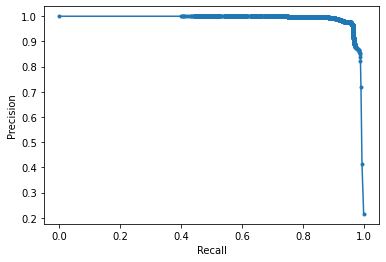

AUC: 0.99
Iteration: 19
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0020 | g_loss: 0.1046 (8.01, 0.02, 1.93) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2835 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1669 seconds



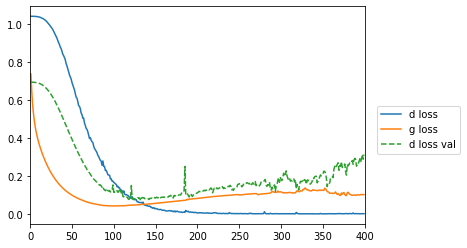

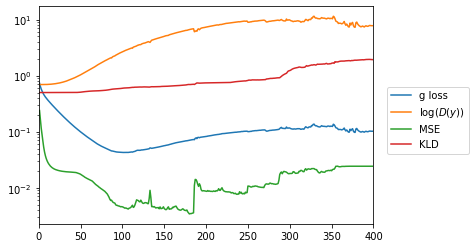

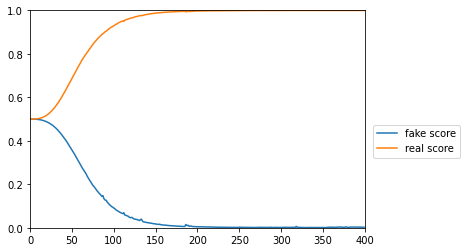

PR AUC: 0.99


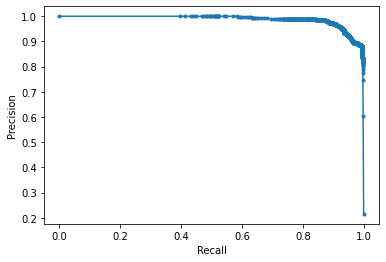

AUC: 1.00
Iteration: 20
[INFO] Starting training phase...
Epoch [400/400] | d_loss: 0.0019 | g_loss: 0.1178 (9.55, 0.02, 1.68) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3423 | D(x_ab): 0.00  
[INFO] Training phase... Elapsed time: 1665 seconds



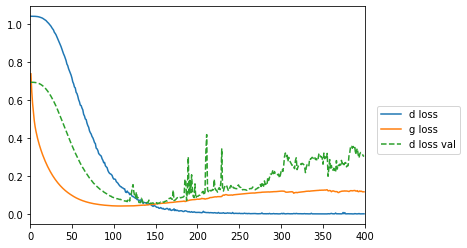

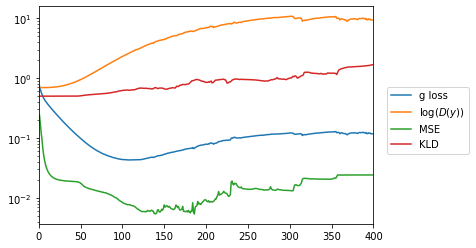

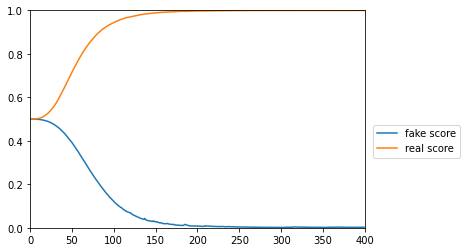

PR AUC: 0.95


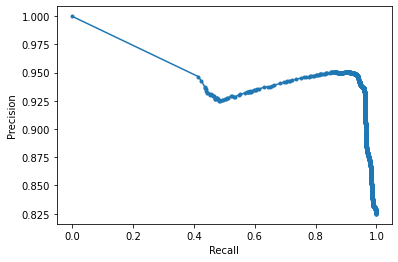

AUC: 0.99


In [7]:
n_runs = 20
auc_list = []
num_epochs = 400
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_KDDCUP99REV(PATH, seed*(i+1), percAnomalies = 0.03, show=False)
    
    train_loader_normal = DataLoader(dataset=torch.FloatTensor(dataset['x_train'][dataset['y_train'] == 1]), 
                          batch_size = batch_size, shuffle=True, drop_last = True)
    
    train_loader_abnormal = DataLoader(dataset=torch.FloatTensor(dataset['x_train'][dataset['y_train'] == 0]), 
                          batch_size = batch_size, shuffle=True, drop_last = False)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = AADNet(device, dataset['x_train'].shape[1])
    d_losses, g_losses, rec_losses, bce_losses, kldes, real_scores, fake_scores, d_losses_val = trainer.train(train_loader_normal, train_loader_abnormal, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save models
    NAME_D = f'D_GCN_SEMIS_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GCN_SEMIS_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, kldes, real_scores, fake_scores, i, DATASET, show = True)
    
    prediction, y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(1-y_true, 1-yP)
    pr = trainer.pr_auc(1-y_true, 1-yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [8]:
meanAUC_PRAUC(auc_list, pr_list, 'GCN_SEMIS_KDDCUP99REV_3P', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.9960593456801177, 0.9876452202630182, 0.9981497316742349, 0.9936937792361722, 0.9867569758638709, 0.994287071036024, 0.97338158145214, 0.9821828234028508, 0.9938560305386896, 0.9845899457359533, 0.9941607737258409, 0.9869230211783273, 0.9844303298712593, 0.9904851527835876, 0.9899141667183569, 0.9805692988757605, 0.9974051504654208, 0.9938222663787496, 0.9960432529583363, 0.9905629300283364]
**************
PR AUC:
[0.9930634796916575, 0.9782231070917072, 0.9944754053227471, 0.9863146333882035, 0.9855008663595402, 0.9774071020223831, 0.9074625341269634, 0.9463731235426105, 0.9925898049910904, 0.9842081795124372, 0.9755277922087887, 0.984754326199132, 0.9816910126031906, 0.9845201941703433, 0.9896980374981603, 0.9256654105468375, 0.9919522809482821, 0.9894329640258965, 0.9878888618989502, 0.9507597868145677]
**************
AUC
0.99 +/- 0.00
95% confidence level, average auc would be between 0.99 and 0.99
**************
PR AUC
0.98 +/- 0.01
95% confidence level, average auc would 